<a href="https://colab.research.google.com/github/umar-faroooq/Jupyter-notebooks/blob/main/auto_encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [62]:
df = pd.read_csv('/content/drive/MyDrive/LSTM Implementation/AHUF5/preprocessed_AHUF5.csv')
date_time = pd.to_datetime(df.pop('Timestamp'))

In [63]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hour,184556.0,11.481442,6.996583,0.00,5.000000,11.000000,18.000000,23.00
day,184556.0,2.983674,2.049272,0.00,1.000000,3.000000,5.000000,6.00
OAT,184556.0,29.578779,4.235406,19.97,26.432292,29.019776,32.603375,43.57
SAT,184556.0,21.532370,6.854144,0.00,18.100000,21.300000,27.100000,34.30
RH,184556.0,56.528214,18.727590,0.00,49.000000,59.000000,70.000000,91.00
CHW_Temp,184556.0,19.317503,7.275348,0.00,15.700000,18.800000,23.600000,34.00
Valve,184556.0,38.702481,48.552425,0.00,0.000000,0.000000,100.000000,100.00
RAT,184556.0,27.146891,6.456997,0.00,27.500000,28.300000,29.300000,35.70


In [64]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [65]:
train_df

,hour,day,OAT,SAT,RH,CHW_Temp,Valve,RAT
0,0,6,25.790000,27.3,35,28.4,100,28.0
1,0,6,25.756667,27.3,35,28.4,100,28.0
2,0,6,25.723333,27.3,35,28.4,100,28.0
3,0,6,25.690000,27.3,35,28.4,100,28.0
4,0,6,25.656667,27.3,35,28.4,100,28.0
...,...,...,...,...,...,...,...,...
129184,23,5,28.104000,25.9,69,24.9,0,27.8
129185,23,5,28.101667,25.9,69,24.9,0,27.8
129186,23,5,28.099333,25.9,69,24.9,0,27.8
129187,23,5,28.097000,25.9,69,24.9,0,27.8


In [66]:
val_df

,hour,day,OAT,SAT,RH,CHW_Temp,Valve,RAT
129189,23,5,28.092333,25.9,69,24.9,0,27.8
129190,0,6,28.090000,25.9,69,24.9,0,27.8
129191,0,6,28.073167,25.9,69,24.9,0,27.8
129192,0,6,28.056333,25.9,69,24.9,0,27.8
129193,0,6,28.039500,25.9,69,24.9,0,27.8
...,...,...,...,...,...,...,...,...
166095,6,1,26.494000,26.8,74,17.1,100,29.4
166096,6,1,26.512000,26.8,74,17.1,100,29.4
166097,7,1,26.530000,26.9,74,17.1,100,29.4
166098,7,1,26.535000,26.9,74,17.2,100,29.5


In [67]:
test_df

,hour,day,OAT,SAT,RH,CHW_Temp,Valve,RAT
166100,7,1,26.545000,26.9,74,17.2,100,29.5
166101,7,1,26.550000,26.9,74,17.2,100,29.5
166102,7,1,26.555000,26.9,74,17.3,100,29.5
166103,7,1,26.560000,27.0,74,17.3,100,29.5
166104,7,1,26.565000,26.9,74,17.3,100,29.5
...,...,...,...,...,...,...,...,...
184551,16,2,33.108571,17.5,65,23.8,0,27.2
184552,16,2,33.082857,17.5,65,23.8,0,27.2
184553,16,2,33.057143,17.5,65,23.8,0,27.2
184554,16,2,33.031429,17.5,65,23.8,0,27.1


In [68]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

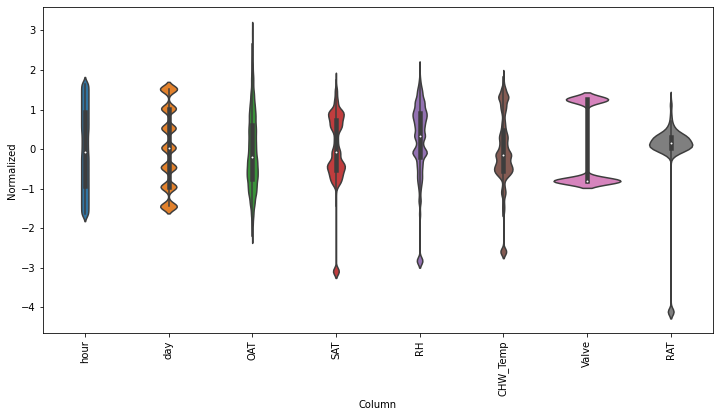

In [69]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [35]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [72]:
OUT_STEPS = 60
multi_window = WindowGenerator(input_width=120,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)


multi_window

Total window size: 180
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179]
Label column name(s): None

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(240, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)



In [78]:

print(history.history.keys())
print(history.history['loss'])
print(history.history['val_loss'])

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
[0.08480369299650192, 0.05520811304450035, 0.0464651882648468]
[0.0831058993935585, 0.08889058232307434, 0.1014290601015091]


In [75]:
IPython.display.clear_output()
multi_val_performance = {}
multi_performance = {}
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)

143/143 [==============================] - 4s 26ms/step - loss: 0.1206 - mean_absolute_error: 0.1584


In [37]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [38]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 180, 8)
Inputs shape: (3, 120, 8)
Labels shape: (3, 60, 1)


In [50]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=128,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [51]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [52]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 120, 8), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name=None))

In [53]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (128, 120, 8)
Labels shape (batch, time, features): (128, 60, 1)


In [54]:
CONV_WIDTH = 6
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=3,
    shift=3,
    label_columns=['RAT'])

conv_window

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [6 7 8]
Label column name(s): ['RAT']

In [55]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [56]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [60]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (128, 6, 8)
Output shape: (128, 1, 1)


In [58]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

289/289 [==============================] - 6s 21ms/step - loss: 0.0107 - mean_absolute_error: 0.0321
